In [9]:
# 0927(0924的延续)

import os, sys
import numpy as np
import random
import molvecgen

import rdkit
from rdkit import Chem, DataStructs, rdBase
from rdkit.Chem import rdFMCS, AllChem, RDKFingerprint, Descriptors, rdMolDescriptors, AllChem, QED
from rdkit import DataStructs
from rdkit.Chem.Draw import IPythonConsole

default_path = os.getcwd()
gasa_path = os.path.join(default_path, "GASA")
if gasa_path not in sys.path:
    sys.path.append(gasa_path)
import gasa

import h5py
import pandas as pd
import ast
import pickle
from ipywidgets import interact

from ddc_pub import ddc_v3 as ddc

# 计算子结构相似度
def get_sim(mol, sub_mol) -> float: 
    try:
        res = rdFMCS.FindMCS([mol, sub_mol], timeout=1, bondCompare=rdFMCS.BondCompare.CompareAny, ringMatchesRingOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)
        if res.smartsString == "" or res.canceled:
            return 0
        mcs_mol = Chem.MolFromSmarts(res.smartsString)
        Chem.SanitizeMol(mcs_mol)

        mcs_mol_fp = RDKFingerprint(mcs_mol)
        sub_mol_fp = RDKFingerprint(sub_mol)
        sim = DataStructs.FingerprintSimilarity(sub_mol_fp, mcs_mol_fp, metric=DataStructs.DiceSimilarity)

        return sim
    except Exception as e:
        #print(e)
        return 0

# 计算合成可及性
def get_gasas(mols: list=[]) -> list:
    if default_path[-4:] != "GASA":
        os.chdir(os.path.join(default_path, "GASA"))
    smiles_list = [Chem.MolToSmiles(mol) for mol in mols]
    gasas = gasa.GASA(smiles_list)[1]
    os.chdir(default_path)
    return gasas

# 计算除了gasas之外的描述符
def get_descriptors(mol, sub_mol) -> list:
    descriptors = []
    if mol:
        try:
            logp = Descriptors.MolLogP(mol)
            tpsa = Descriptors.TPSA(mol)
            sim = get_sim(mol, sub_mol)
            hba = rdMolDescriptors.CalcNumHBA(mol)
            hbd = rdMolDescriptors.CalcNumHBD(mol)
            qed = QED.qed(mol)
            molwt = Descriptors.ExactMolWt(mol)

            descriptors = [logp, tpsa, sim, qed, hba, hbd, molwt]
        except Exception as e:
            #print(e)
            return descriptors
    else:
        print("Invalid generation.")
    return descriptors

# 关闭输出
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

# 生成器
class mol_generator:
    def __init__(self, seed_smile:str = "", sub_smile:str = "", model = None, target_names:list = [], qsar_model:str = ""):
        self.mols = []
        self.target = []
        self.target_names = target_names
        self.sani_mols = []
        self.sani_properties = []
        self.data = None
        self.set_seed(seed_smile)
        self.set_sub(sub_smile)
        self.set_model(model)
        self.set_qsar_model(qsar_model)

    def set_seed(self, seed_smile):
        if seed_smile == "":
            return
        #self.seed_smile = seed_smile
        self.seed_mol = Chem.MolFromSmiles(seed_smile)

        print("Seed Molecular:")
        print(Chem.MolToSmiles(self.seed_mol))

    def set_sub(self, sub_smile):
        if sub_smile == "":
            return
        self.sub_mol = Chem.MolFromSmiles(sub_smile)

        print("Substruct:")
        print(Chem.MolToSmiles(self.sub_mol))

    def set_model(self, model):
        if model == "":
            return

        #根据model参数的类型，从文件载入模型或直接接收trainer的模型
        if type(model)==str:
            self.model = ddc.DDC(model_name=model)
        else:
            self.model = model

    def set_qsar_model(self, qsar_model):
        if(qsar_model == ""):
            return
        self.qsar_model = pickle.load(open(qsar_model, "rb"))["classifier_sv"]

    # 检查分子
    def sanitize(self, mol):  
        try:
            Chem.SanitizeMol(mol)
            if Chem.MolToSmiles(mol) == "":
                return None
            else:
                return mol
        except Exception as e:
            return None
            #print(e)

    # 计算目标
    def get_target(self, conditions: list=[]):
        target = get_descriptors(self.seed_mol, self.sub_mol)
        target.append(get_gasas([self.seed_mol])[0])
        #print(conditions, target)
        for idx,condition in enumerate(conditions):
            if idx >= len(target):
                break
            if condition != None:
                target[idx] = condition
        return np.asarray(target)

    # 采样指定性质的分子
    def sample(self, sample_times: int = 4, conditions: list = []):
        # 确定目标
        self.target = self.get_target(conditions)
        print("Sampling with target:{:}.".format(self.target))

        # 采样
        smiles_out = []
        self.model.batch_input_length = 256  # 太大会减慢速度
        for i in range(sample_times):
            smiles, _ = self.model.predict_batch(latent=self.target.reshape(1, -1), temp=1.0)
            #print("#{:}:{:}".format(i,smiles))
            smiles_out.append(smiles)
        smiles_out = np.concatenate(smiles_out)
        self.mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]

        # 检查分子
        print("Checking mols.")
        self.sani_properties.clear()
        self.sani_fps = []
        sani_mols = []
        for idx,mol in enumerate(self.mols):
            sani_mol = self.sanitize(mol)
            if sani_mol != None:
                #去重
                mol_fp = RDKFingerprint(sani_mol)
                is_dupli = False
                for i in self.sani_fps:
                    sani_sim = DataStructs.FingerprintSimilarity(mol_fp, i)
                    if sani_sim == 1.0:
                        is_dupli = True
                        break
                if not is_dupli:
                    self.sani_fps.append(mol_fp)
                    sani_properties = get_descriptors(sani_mol, self.sub_mol)
                    sani_properties.insert(0, smiles_out[idx])
                    sani_properties.insert(0, sani_mol)
                    sani_mols.append(sani_mol)
                    self.sani_properties.append(sani_properties)
        
        # 计算GASA score
        print("Calculating GASA score for generated mols.")
        sani_gasas = get_gasas(sani_mols)
        for idx,properties in enumerate(self.sani_properties):
            properties.append(sani_gasas[idx])

        # 打印结果
        self.data = pd.DataFrame(self.sani_properties, columns=['mol','smiles']+self.target_names)
        print("Generated mols:{:}, sanitized mols:{:}, validity:{:}".format(len(self.mols), len(self.sani_properties), len(self.sani_properties)/len(self.mols)))

    # 根据id显示生成的分子
    def showmol(self, i):  
        print(Chem.MolToSmiles(self.sani_properties[i][0]))

    # 筛选分子
    def filter_data(self):
        #筛选结果
        #print("Saving results.")
        binmols = np.asarray([i[0].ToBinary() for i in self.sani_properties])
        combined_properties = []
        for idx,binmol in enumerate(binmols):
            combined_properties.append([binmol] + self.sani_properties[idx][2:])

        combined_data = pd.DataFrame(combined_properties, columns=['binmols']+self.target_names)
        #print(combined_data.keys())
        combined_data = combined_data.sort_values(['gasas'])
        #print(combined_data.sort_values(['sub_similarity']).tail(10)['sub_similarity'])

        filter_list = [i >= 0.8 for i in combined_data['sub_similarity']]
        '''for idx,sim in enumerate(combined_data['sub_similarity']):
            filter_list.append(float(sim) >= 0.8 and float(combined_data['gasas'][idx]) > 0.25)'''
        filtered_properties_data = combined_data.loc[filter_list]

        print("Filtered {} mols.".format(len(filtered_properties_data)))

        return (filtered_properties_data)
    
    # 导出数据
    def dump(self, filename:str = "", data = None):
        with open(filename, "wb") as f:
            pickle.dump(data, f)

    # 加载数据
    def load_data_old(self, mols_filename:str = "", properties_filename:str = ""):
        with open(mols_filename, "rb") as f:
            sani_mols = pickle.load(f)
        with open(properties_filename, "rb") as f:
            sani_properties = pickle.load(f)

        assert len(sani_mols) == len(sani_properties)
        for i in range(len(sani_mols)):
            sani_properties[i].insert(0, '')
            sani_properties[i].insert(0, sani_mols[i])

        self.sani_properties = sani_properties
        self.data = pd.DataFrame(self.sani_properties, columns=['mol','smiles']+self.target_names)
        print("Loaded {} mols with properties.".format(len(self.data))) 
    
    def load_data(self, properties_filename:str = ""):
        with open(properties_filename, "rb") as f:
            self.sani_properties = pickle.load(f)
        self.data = pd.DataFrame(self.sani_properties, columns=['mol','smiles']+self.target_names) 
        print("Loaded {} mols with properties.".format(len(self.data))) 
    
    # 以表格形式显示生成的分子的属性
    def show_data(self, n=5):  
        display(self.data.head(n))

    # 绘制样本分布
    def plot(self):
        try:
            target_dict = {t[0]: t[1] for t in zip(self.target_names, self.target)}
            axes = self.data[2:].hist(bins=25, figsize=(8, 6))
            for i, ax in enumerate(axes.flatten()):
                title = ax.title.__dict__["_text"]
                if title:
                    ax.axvline(x=target_dict[title], color='r', linestyle='dashed', linewidth=2)
        except Exception as e:
            print(e)
            pass

    def interact(self):  # 显示下拉菜单
        _ = interact(self.showmol, i=range(len(self.sani_mols)))

In [10]:
target_names = ["logp", "tpsa", "sub_similarity", "qed", "hba", "hbd", "molwt", "gasa_score"]
sub_smiles = "O=C(OC)C1=CC(C2=O)CCCC2C1=O"
seed_smiles = "CC1(C)C(CCC2(C)C1CCC(C34C)(C)C2CC(C)(C4=O)C(C)=C(C(OC)=O)C3=O)=O"

# generators = [mol_generator(target_names=target_names, seed_smile=seed_smiles, sub_smile=sub_smiles, model="models/model_0924_{}".format(i)) for i in range(4)]
generators = [mol_generator(target_names=target_names, seed_smile=seed_smiles, sub_smile=sub_smiles) for i in range(4)]


Seed Molecular:
COC(=O)C1=C(C)C2(C)CC3C4(C)CCC(=O)C(C)(C)C4CCC3(C)C(C)(C1=O)C2=O
Substruct:
COC(=O)C1=CC2CCCC(C1=O)C2=O
Seed Molecular:
COC(=O)C1=C(C)C2(C)CC3C4(C)CCC(=O)C(C)(C)C4CCC3(C)C(C)(C1=O)C2=O
Substruct:
COC(=O)C1=CC2CCCC(C1=O)C2=O
Seed Molecular:
COC(=O)C1=C(C)C2(C)CC3C4(C)CCC(=O)C(C)(C)C4CCC3(C)C(C)(C1=O)C2=O
Substruct:
COC(=O)C1=CC2CCCC(C1=O)C2=O
Seed Molecular:
COC(=O)C1=C(C)C2(C)CC3C4(C)CCC(=O)C(C)(C)C4CCC3(C)C(C)(C1=O)C2=O
Substruct:
COC(=O)C1=CC2CCCC(C1=O)C2=O


In [ ]:
#generator.sample(4, [None]*6+[7.5])
for generator in generators:
    generator.sample(4, [None]*7+[0.9])
    generator.plot()
    #generator.dump("datasets/generator_0919_m.pickle", generator.sani_mols)
    #generator.dump("datasets/generator_0919_p.pickle", generator.sani_properties)

In [11]:
for i,generator in enumerate(generators):
    print("model_0924_{}:".format(i+4))
    generator.load_data("datasets/generator_0924_{}.pickle".format(i+4))
    generator.target = generator.get_target([None]*7+[0.9])
    #generator.data = pd.DataFrame(generator.sani_properties, columns=generator.target_names, copy=True)
    generator.plot()

model_0924_4:
Loaded 14397 mols with properties.
Use the manually specified hyperparameters
Created directory gasa/results/145
No module named 'matplotlib.artist'
model_0924_5:
Loaded 15069 mols with properties.
Use the manually specified hyperparameters
Created directory gasa/results/146
No module named 'matplotlib.artist'
model_0924_6:
Loaded 17328 mols with properties.
Use the manually specified hyperparameters
Created directory gasa/results/147
No module named 'matplotlib.artist'
model_0924_7:
Loaded 17654 mols with properties.
Use the manually specified hyperparameters
Created directory gasa/results/148
No module named 'matplotlib.artist'


In [12]:
for generator in generators:
    generator.plot()

In [10]:
for idx,generator in enumerate(generators):
    print(idx+4)
    filter_list = [i == 1 for i in generator.data['sub_similarity']]
    filtered_data = generator.data.loc[filter_list]
    print(len(generator.data))
    display(filtered_data.sort_values("gasa_score").tail(10))

4
7632


,logp,tpsa,sub_similarity,qed,hba,hbd,molwt,gasa_score
1340,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.737112
4495,4.47190,77.51,1.0,0.368317,5,0,428.256274,0.738130
7099,5.04258,84.23,1.0,0.324489,5,0,439.272259,0.749203
105,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.757680
3821,4.47190,77.51,1.0,0.368317,5,0,428.256274,0.763513
592,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.770263
4017,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.782702
37,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.800943
2380,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.801984
76,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.810702


5
7632


,logp,tpsa,sub_similarity,qed,hba,hbd,molwt,gasa_score
1340,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.737112
4495,4.47190,77.51,1.0,0.368317,5,0,428.256274,0.738130
7099,5.04258,84.23,1.0,0.324489,5,0,439.272259,0.749203
105,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.757680
3821,4.47190,77.51,1.0,0.368317,5,0,428.256274,0.763513
592,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.770263
4017,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.782702
37,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.800943
2380,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.801984
76,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.810702


6
7632


,logp,tpsa,sub_similarity,qed,hba,hbd,molwt,gasa_score
1340,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.737112
4495,4.47190,77.51,1.0,0.368317,5,0,428.256274,0.738130
7099,5.04258,84.23,1.0,0.324489,5,0,439.272259,0.749203
105,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.757680
3821,4.47190,77.51,1.0,0.368317,5,0,428.256274,0.763513
592,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.770263
4017,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.782702
37,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.800943
2380,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.801984
76,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.810702


7
7632


,logp,tpsa,sub_similarity,qed,hba,hbd,molwt,gasa_score
1340,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.737112
4495,4.47190,77.51,1.0,0.368317,5,0,428.256274,0.738130
7099,5.04258,84.23,1.0,0.324489,5,0,439.272259,0.749203
105,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.757680
3821,4.47190,77.51,1.0,0.368317,5,0,428.256274,0.763513
592,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.770263
4017,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.782702
37,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.800943
2380,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.801984
76,4.47190,77.51,1.0,0.349746,5,0,428.256274,0.810702


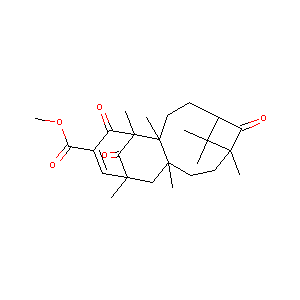

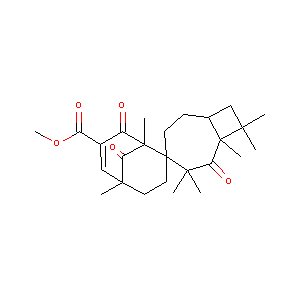

In [7]:
generators[3].showmol(76)
generators[3].showmol(2380)

In [ ]:
filename = "datasets/generator_0924_0.pickle"
with open(filename, "rb") as f:
    loaded_data = pickle.load(f)
print(len(loaded_data))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\Anaconda3\envs\ddc_env\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-581aeaf00c09>", line 4, in <module>
    print(len(loaded_data))
  File "D:\Anaconda\Anaconda3\envs\ddc_env\lib\site-packages\pandas\core\frame.py", line 981, in __len__
    return len(self.index)
  File "D:\Anaconda\Anaconda3\envs\ddc_env\lib\site-packages\pandas\core\generic.py", line 5175, in __getattr__
    return object.__getattribute__(self, name)
  File "pandas\_libs\properties.pyx", line 63, in pandas._libs.properties.AxisProperty.__get__
AttributeError: 'NoneType' object has no attribute 'axes'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\Anaconda3\envs\ddc_env\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceb

In [25]:
smiles_data = np.asarray([Chem.MolToSmiles(mol) for mol in generator.sani_mols])
smiles_data = pd.DataFrame(smiles_data, columns=["smiles"], copy=True)
smiles_data.to_csv("datasets/model_0919_smiles.csv")
generator.data.to_csv("datasets/model_0919_properties.csv")